# Simple circuit

### Design

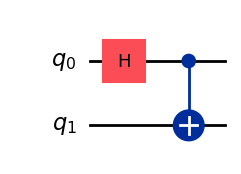

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw("mpl")

In [2]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

### Optimise

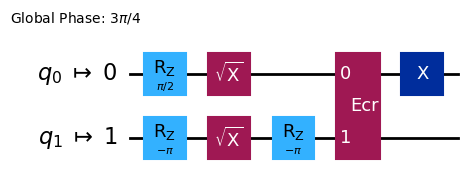

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

pm_1 = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit_1 = pm_1.run(qc)

isa_circuit_1.draw("mpl", idle_wires=False)


### Execute

In [12]:
estimator = EstimatorV2(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit_1.layout) for observable in observables
]

job = estimator.run([(isa_circuit_1, mapped_observables)])

print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cz7c4tvh0kc00089dzcg


In [15]:
job_results = job.result()

pub_results = job.result()[0]

In [23]:
#FAKE SIMULATIONS
# Use the following code instead if you want to run on a simulator:
 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend_fake = FakeAlmadenV2()
estimator_fake = EstimatorV2(backend_fake)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm_fake = generate_preset_pass_manager(backend=backend_fake, optimization_level=1)
isa_circuit_fake = pm_fake.run(qc)
mapped_observables_fake = [
    observable.apply_layout(isa_circuit_fake.layout) for observable in observables
]
 
job_fake = estimator_fake.run([(isa_circuit_fake, mapped_observables_fake)])
result_fake = job_fake.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_results_fake = job_fake.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_results_fake = job_fake.result()[0]

### Analise

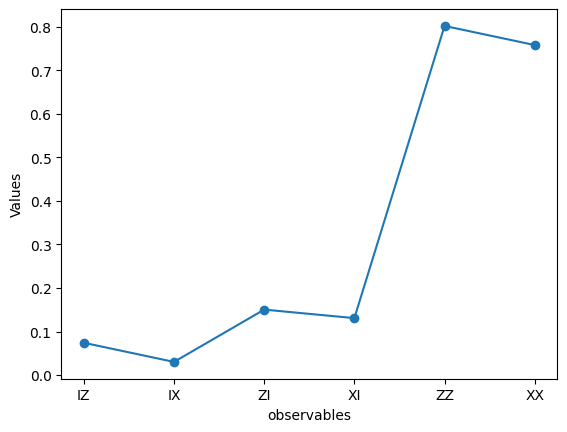

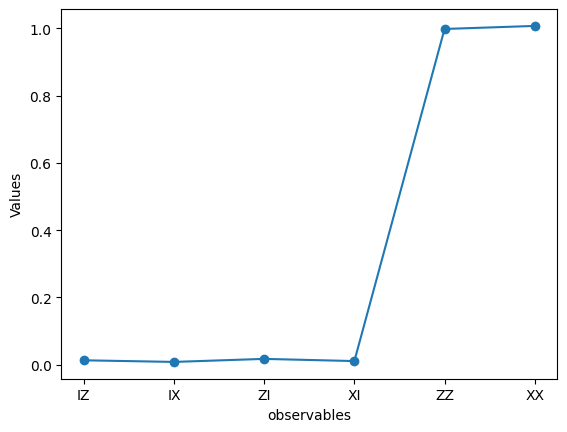

In [ ]:
from matplotlib import pyplot as plt
#FAKE DATA
values = pub_results_fake.data.evs

errors = pub_results_fake.data.stds

plt.plot(observables_labels, values, "-o")
plt.xlabel("observables")
plt.ylabel("Values")
plt.show()

#REAL DATA
values = pub_results.data.evs

errors = pub_results.data.stds

plt.plot(observables_labels, values, "-o")
plt.xlabel("observables")
plt.ylabel("Values")
plt.show()

# Scale to large nubmers of qubits

### Design

In [36]:
from qiskit import QuantumCircuit

def get_qc_for_n_qubits_GHZ_state(n: int) -> QuantumCircuit:
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc

n = 100
qc_100_qubits = get_qc_for_n_qubits_GHZ_state(n)

In [38]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n-2-i) for i in range(n-1)
]
print(operator_strings)

operators_100_qubits = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Optimise

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)

pm_100_qubits = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit_100_qubits = pm_100_qubits.run(qc_100_qubits)
isa_operators_list = [op.apply_layout(isa_circuit_100_qubits.layout) for op in operators_100_qubits]

### Execute

In [52]:
from qiskit_ibm_runtime import EstimatorOptions, EstimatorV2

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XpXm"

estimator = EstimatorV2(backend, options=options)

job = estimator.run([(isa_circuit_100_qubits, isa_operators_list)])
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cz7fhtfkvm9g008grmcg


### Analise

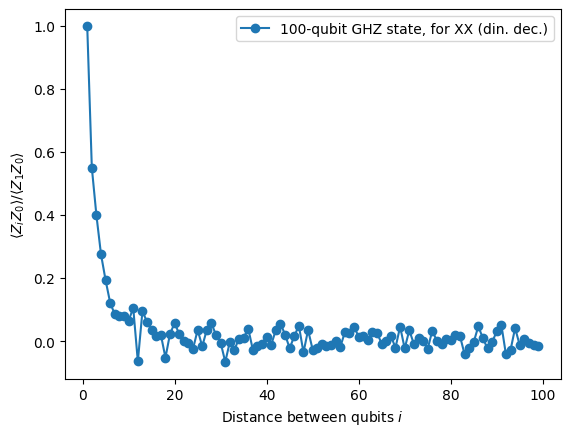

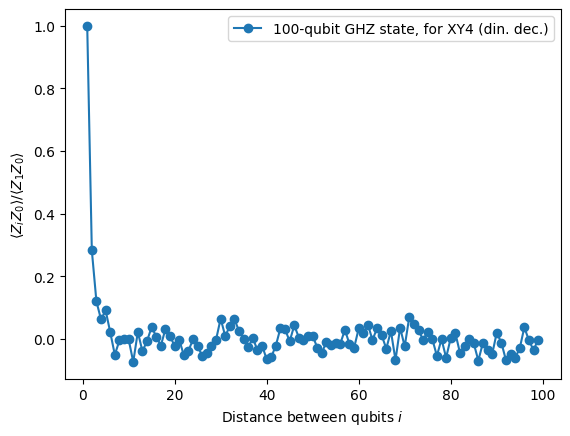

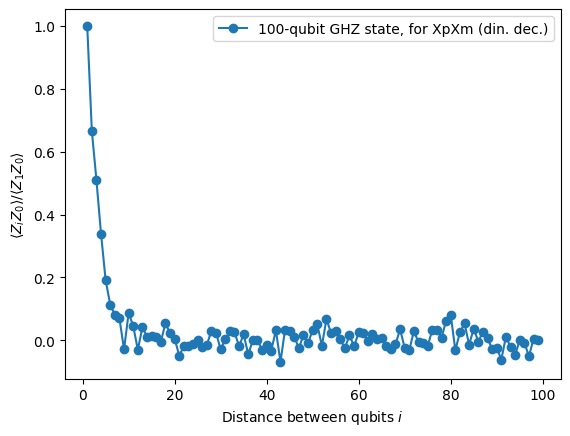

In [53]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
# ID for options.dynamical_decoupling.sequence_type = "XX" --> cz7fetvkvm9g008grkw0

job_id = 'cz7fetvkvm9g008grkw0'

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

data = list(range(1, len(operators_100_qubits) + 1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.plot(data, values, marker="o", label = "100-qubit GHZ state, for XX (din. dec.)")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

###############################
#         For the other       #
###############################

# ID for options.dynamical_decoupling.sequence_type = "XY4" --> cz7f9z739f40008syr0g

job_id = 'cz7f9z739f40008syr0g'

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

data = list(range(1, len(operators_100_qubits) + 1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.plot(data, values, marker="o", label = "100-qubit GHZ state, for XY4 (din. dec.)")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

###############################
#         For the other       #
###############################

# ID for options.dynamical_decoupling.sequence_type = "XpXm" --> cz7fhtfkvm9g008grmcg

job_id = 'cz7fhtfkvm9g008grmcg'

service = QiskitRuntimeService()
job = service.job(job_id)
result = job.result()

data = list(range(1, len(operators_100_qubits) + 1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.plot(data, values, marker="o", label = "100-qubit GHZ state, for XpXm (din. dec.)")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()